# MRI Brain Tumor Classification with Augmentation and Preprocessing
Ova bilježnica prikazuje kako koristiti augmentaciju i osnovnu predobradu slika za poboljšanje performansi modela za klasifikaciju tumora mozga na MRI slikama.

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import cv2
import imutils
import shutil

2025-06-08 22:18:23.572624: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-08 22:18:23.581996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749413903.593693  124929 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749413903.597071  124929 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749413903.606172  124929 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

## Učitavanje i augmentacija podataka
Koristimo `tf.keras.preprocessing` slojeve za augmentaciju i predobradu slika.

In [ ]:
# Parametri
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# === CROPPING SECTION: Run this cell ONCE to crop and save images, then comment it out ===
# If you have already cropped and saved images, you can skip running this cell again.
def crop_brain_contour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) == 0:
        return image
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    cropped = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    return cropped

input_dir = "../data/BinaryBrainTumorDataset/Training"
output_dir = "../data/CroppedBinaryBrainTumorDataset/Training"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir, exist_ok=True)

for label in os.listdir(input_dir):
    label_in = os.path.join(input_dir, label)
    label_out = os.path.join(output_dir, label)
    os.makedirs(label_out, exist_ok=True)
    for fname in os.listdir(label_in):
        fpath = os.path.join(label_in, fname)
        img = cv2.imread(fpath)
        if img is not None:
            cropped = crop_brain_contour(img)
            resized = cv2.resize(cropped, (224, 224))
            cv2.imwrite(os.path.join(label_out, fname), resized)
# === END CROPPING SECTION ===

# Učitavanje podataka iz croppanog direktorija
train_dataset = image_dataset_from_directory(
    "../data/CroppedBinaryBrainTumorDataset/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="binary",
    validation_split=0.2,
    subset="training",
    seed=SEED
)

val_dataset = image_dataset_from_directory(
    "../data/CroppedBinaryBrainTumorDataset/Training",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="binary",
    validation_split=0.2,
    subset="validation",
    seed=SEED
)

class_names = train_dataset.class_names
print("Klase:", class_names)

Found 5712 files belonging to 2 classes.
Using 4570 files for training.


I0000 00:00:1749413905.501084  124929 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3530 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 5712 files belonging to 2 classes.
Using 1142 files for validation.
Klase: ['no', 'yes']


In [3]:
# Normalizacija piksela i augmentacija
preprocessing_and_augmentation = keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1),
])

def preprocess(images, labels):
    return preprocessing_and_augmentation(images), labels

augmented_train = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(lambda x, y: (layers.Rescaling(1./255)(x), y), num_parallel_calls=tf.data.AUTOTUNE)

augmented_train = augmented_train.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

## Vizualizacija augmentiranih slika

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11101769..1.0155629].
2025-06-08 22:18:27.380042: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


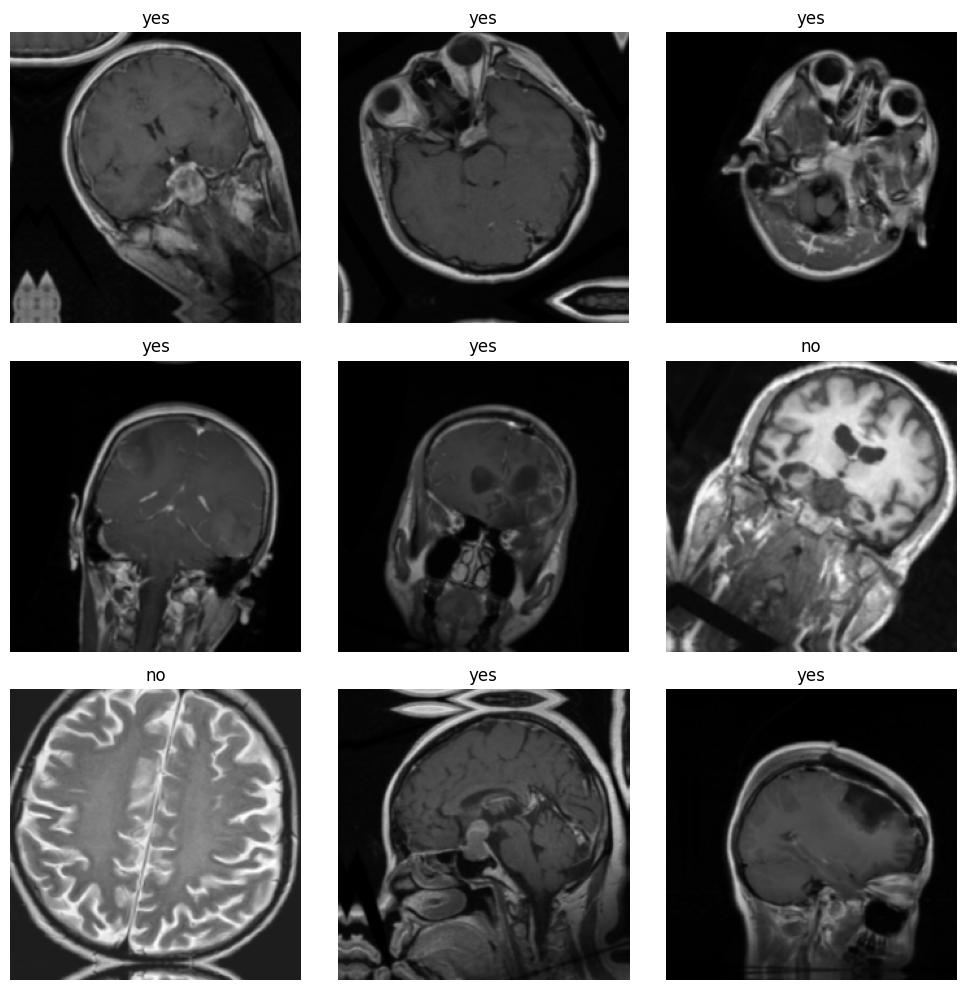

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in augmented_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy()
        plt.imshow(img)
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

## Definicija CNN modela

In [10]:
model = Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,825 (84.86 MB)

 Trainable params: 22,245,377 (84.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [6]:
# Callback funkcije
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_augmented_model.keras', save_best_only=True, monitor='val_loss')

In [11]:
# Treniranje modela
history = model.fit(
    augmented_train,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint]
)

model.save('final_augmented_model.keras')

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.8360 - loss: 0.7380 - val_accuracy: 0.7504 - val_loss: 1.2488
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9231 - loss: 0.2210 - val_accuracy: 0.8643 - val_loss: 0.5097
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9346 - loss: 0.1937 - val_accuracy: 0.9107 - val_loss: 0.2881
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9428 - loss: 0.1811 - val_accuracy: 0.9448 - val_loss: 0.1546
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9513 - loss: 0.1474 - val_accuracy: 0.9562 - val_loss: 0.1385
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.9613 - loss: 0.1313 - val_accuracy: 0.9694 - val_loss: 0.0958
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9572 - loss: 0.1229 - val_accuracy: 0.9457 - val_loss: 0.1612
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9561 - loss: 0.1326 - val_acc

## Evaluacija modela

2025-06-08 22:23:18.054674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


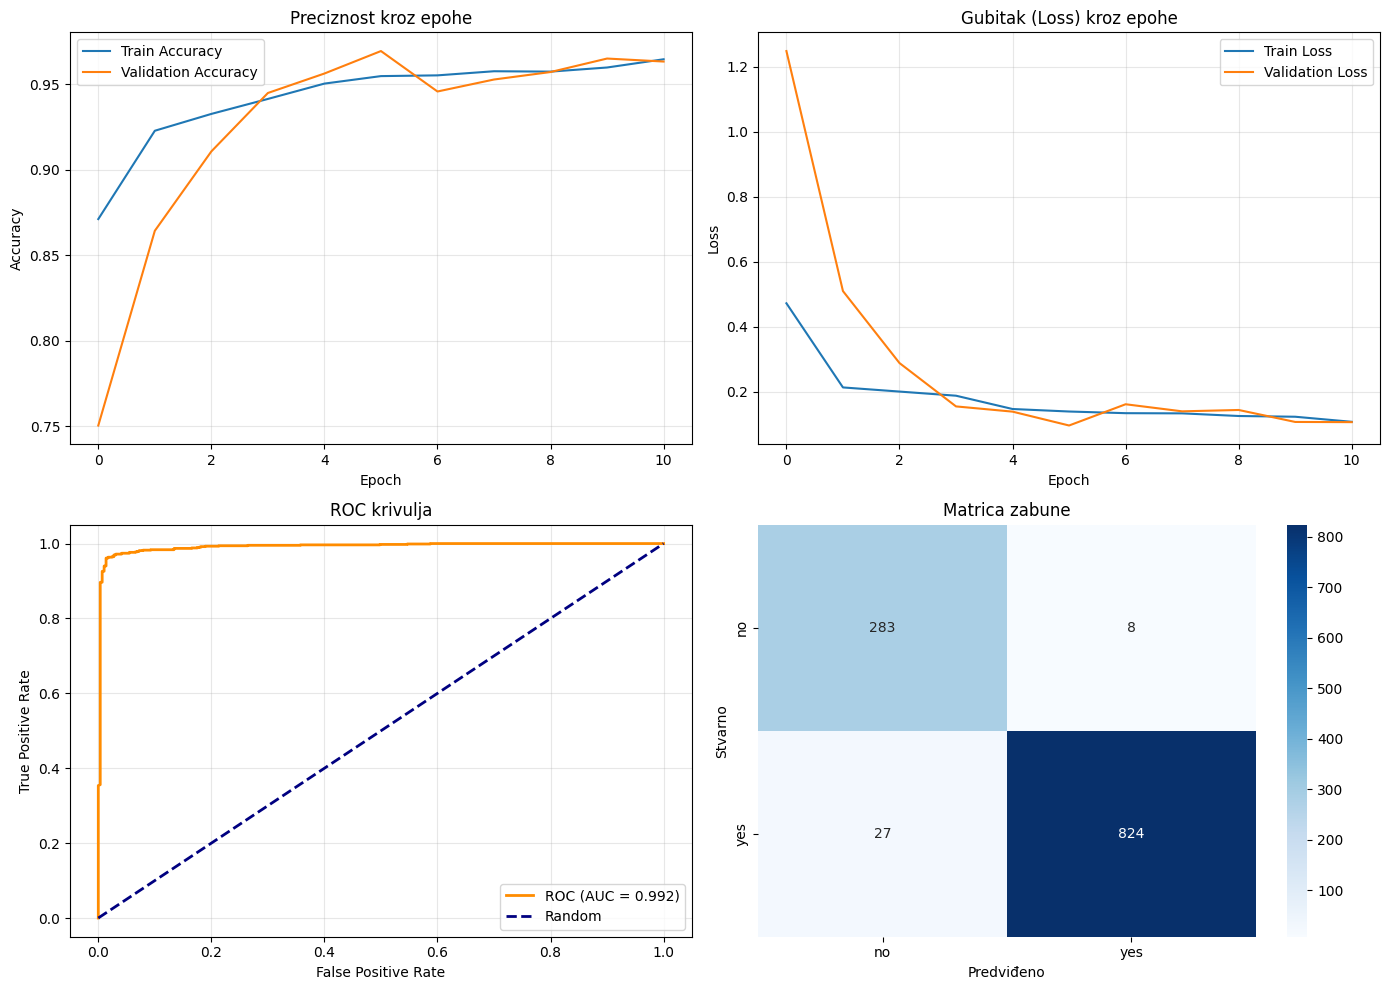

Točnost (accuracy): 0.9694
Preciznost (precision): 0.9904
F1 rezultat: 0.9792
AUC-ROC: 0.9921

Izvještaj o klasifikaciji:
              precision    recall  f1-score   support

          no       0.91      0.97      0.94       291
         yes       0.99      0.97      0.98       851

    accuracy                           0.97      1142
   macro avg       0.95      0.97      0.96      1142
weighted avg       0.97      0.97      0.97      1142



In [12]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, precision_score, accuracy_score
import seaborn as sns

best_model = keras.models.load_model('best_augmented_model.keras')

y_true = []
y_pred_proba = []
y_pred = []

for images, labels in val_dataset:
    predictions = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred_proba.extend(predictions.flatten())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Preciznost kroz epohe
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Preciznost kroz epohe')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gubitak kroz epohe
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Gubitak (Loss) kroz epohe')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ROC krivulja
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC krivulja')
axes[1, 0].legend(loc="lower right")
axes[1, 0].grid(True, alpha=0.3)

# Matrica zabune
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axes[1, 1])
axes[1, 1].set_title('Matrica zabune')
axes[1, 1].set_xlabel('Predviđeno')
axes[1, 1].set_ylabel('Stvarno')

plt.tight_layout()
plt.show()

print(f"Točnost (accuracy): {accuracy:.4f}")
print(f"Preciznost (precision): {precision:.4f}")
print(f"F1 rezultat: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

print('\nIzvještaj o klasifikaciji:')
print(classification_report(y_true, y_pred, target_names=class_names))

**Potencijalna poboljšanja:**
- Proširiti i uravnotežiti skup podataka.
- Primijeniti naprednije arhitekture (npr. transfer learning s ResNet, EfficientNet).
- Uvesti dodatne tehnike augmentacije.
- Optimizirati hiperparametre i koristiti regularizaciju.